# Training machine learning models on tabular data: an end-to-end example

This tutorial covers the following steps:
- Import data from your local machine
- Visualize the data using Seaborn and matplotlib
- Run a parallel hyperparameter sweep to train machine learning models on the dataset
- Explore the results of the hyperparameter sweep with MLflow
- Register the best performing model in MLflow
- Apply the registered model to another dataset using a Spark UDF
- Set up model serving for low-latency requests

In this example, you build a model to predict the quality of Portugese "Vinho Verde" wine based on the wine's physicochemical properties.

The example uses a dataset from the UCI Machine Learning Repository, presented in [*
Modeling wine preferences by data mining from physicochemical properties*](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub) [Cortez et al., 2009].

## Requirements
This notebook requires Pyspark.

## Install Pyspark
  
In this section, you use a script automation tool designed to streamline the process of setting up Apache Spark, a widely-used distributed computing system, along with PySpark, which is the Python API for Spark. It's not a default feature of Collab.


In [32]:
# -*- coding: utf-8 -*-
import os # libreria de manejo del sistema operativo

print("Install JAVA 8")
os.system(f"apt-get install openjdk-8-jdk-headless -qq > /dev/null")
os.system(f"pip install wget")

print("Obtaining last version of spark")

from bs4 import BeautifulSoup
import requests, wget

#Obtener las versiones de spark la pagina web
url = 'https://downloads.apache.org/spark/'
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

# leer la pagina web y obtener las versiones de spark disponibles
link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]

ver_spark = spark_link[-1][:-1] # obtener la version y eliminar el caracter '/' del final
print(f"Getting version {ver_spark}")

#instalar automaticamente la version deseadda de spark
download_spark = f"https://downloads.apache.org/spark/{ver_spark}/{ver_spark}-bin-hadoop3.tgz"
print(f"Downloading {download_spark}")
file_name = wget.download(download_spark)
os.system(f"tar xf {ver_spark}-bin-hadoop3.tgz")
# instalar pyspark
print("Installing PySpark")
os.system(f"pip install -q pyspark")

"""## Definir variables de entorno"""
print("Setting environment variables for JAVA_HOME and SPARK_HOME")
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{ver_spark}-bin-hadoop3"




Install JAVA 8
Obtaining last version of spark
Getting version spark-3.5.0
Installing PySpark
Setting environment variables for JAVA_HOME and SPARK_HOME


Overall, this script is used to set up an environment in Google Colab for working with Spark, a powerful tool for handling big data processing and analysis, while also leveraging Pandas for data manipulation tasks.

In [34]:
import pandas as pd
from google.colab import files

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()



We load the two csv files into panda objects with Apache Spark. Apache Spark is not strictly necessary for loading CSV files, especially if the data size is manageable within the memory and processing capabilities of conventional data processing tools like Pandas in Python. However, there are several scenarios where using Apache Spark to load and process CSV files becomes advantageous or even necessary like handling large datasets.

In [16]:
white_wineS = spark.read.option("delimiter", ";").csv('/content/winequality-red.csv', header="true", inferSchema="true")
red_wineS = spark.read.option("delimiter", ";").csv('/content/winequality-white.csv', header="true", inferSchema="true")

white_wine = white_wineS.toPandas()
red_wine = red_wineS.toPandas()

Merge the two DataFrames into a single dataset, with a new binary feature "is_red" that indicates whether the wine is red or white.


In [35]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [18]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


##Visualize data

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

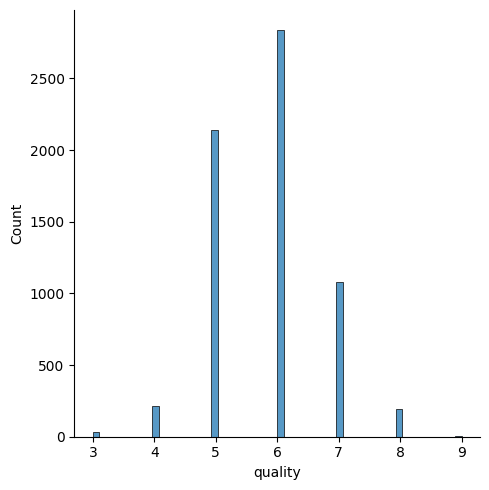

In [19]:
import seaborn as sns
sns.displot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7. We can then transform the 'quality' feature of a wine dataset into a binary classification of high and low quality. Instead of the original numeric quality scores, the quality column now contains 1 for high-quality wines and 0 for others.


In [20]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful in noticing correlations between features and a binary label.


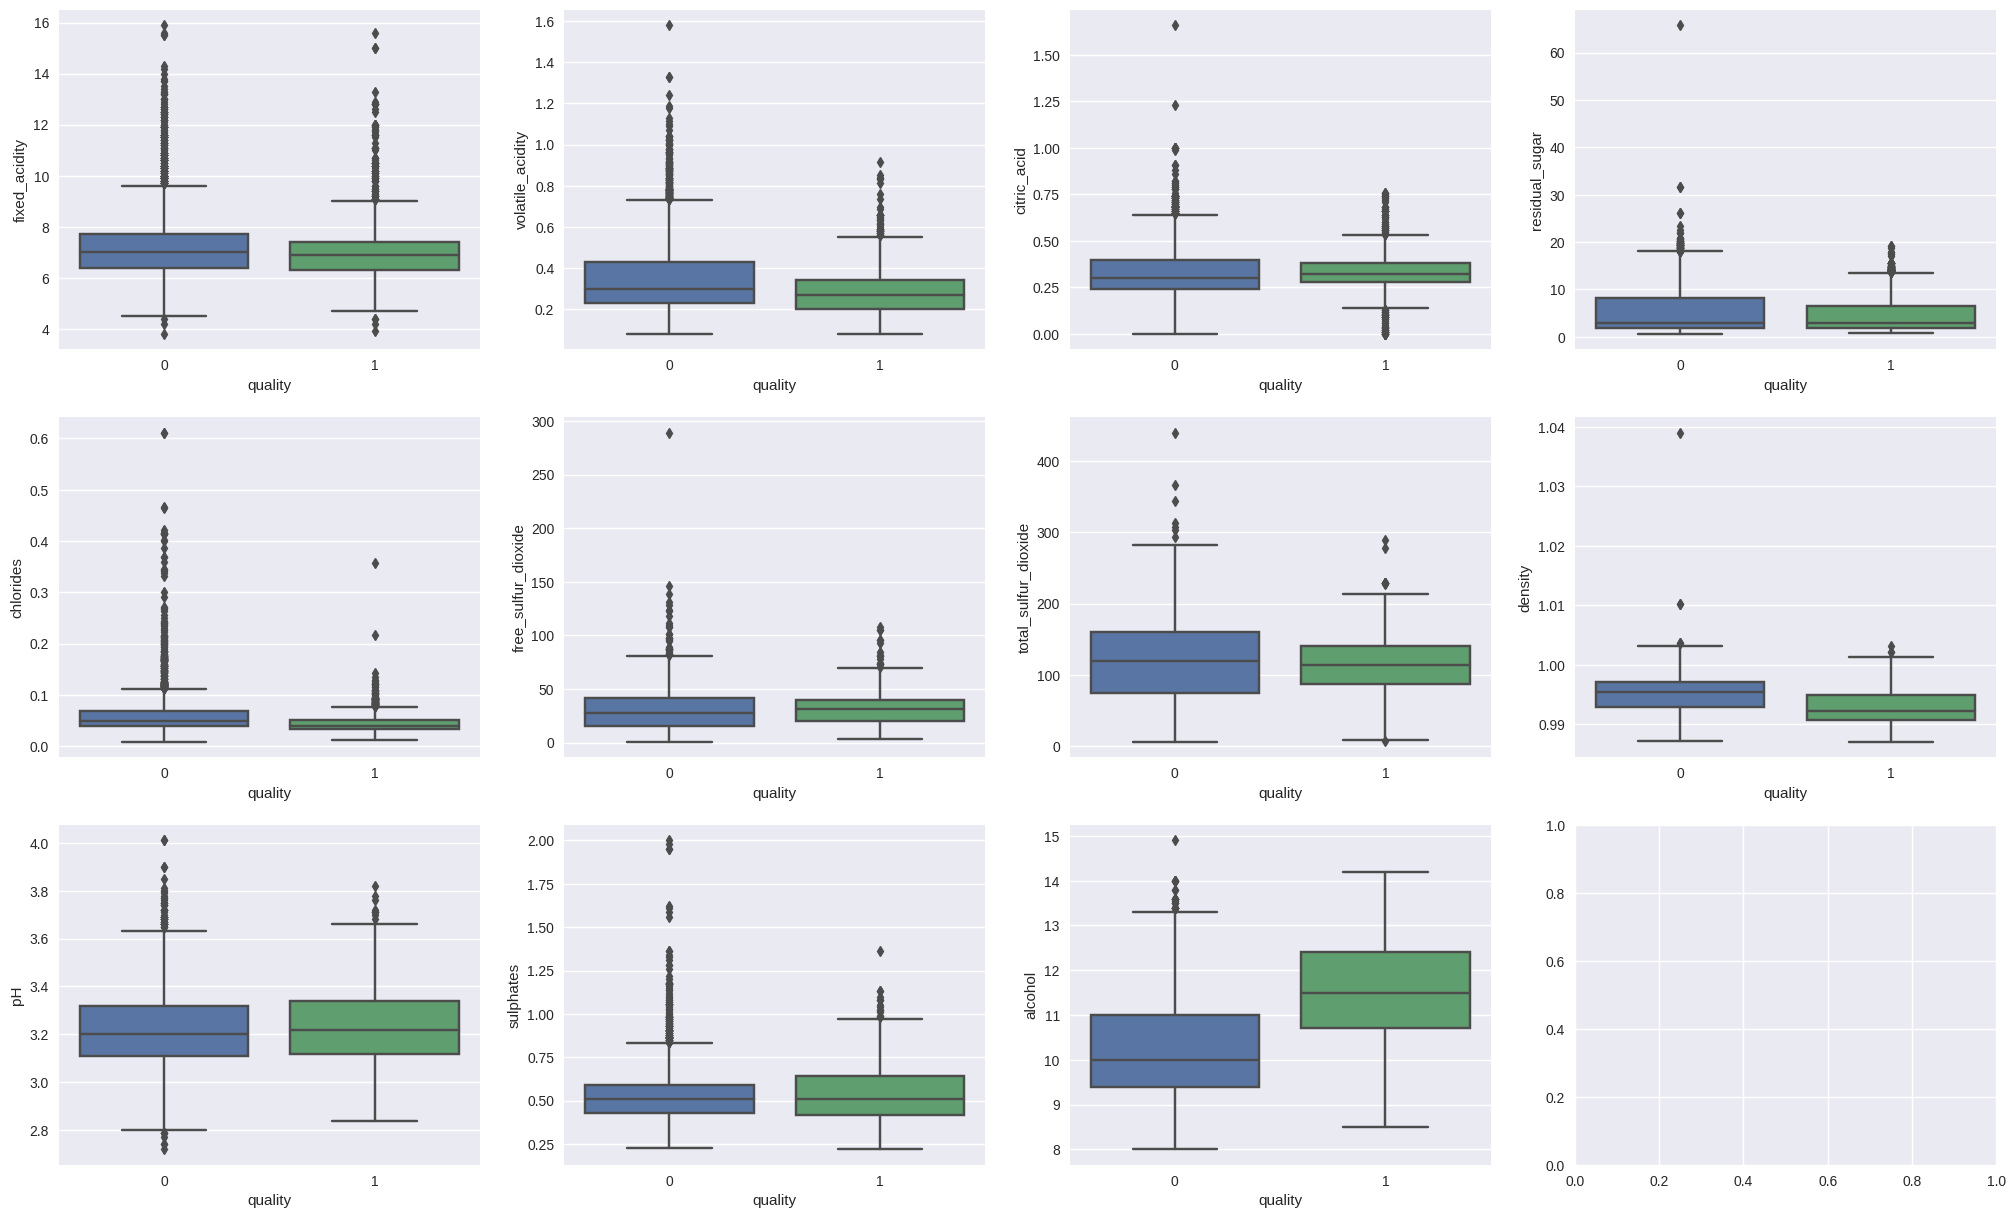

In [38]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality.

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocess data
Prior to training a model, check for missing values and split the data into training and validation sets.

In [22]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

This function returns a boolean value for each column indicating whether any missing values (NaN) exist but there are no missing values (noice).

We will need to split the data in two datasets, one to train the model and another to test it.


In [23]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

## Build a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Random forest behaves well avoiding overfitting (too similar to the trained data).

The following code builds a simple classifier using scikit-learn.


In [39]:
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1).
# The following code creates a wrapper function, SklearnModelWrapper, that uses
# the predict_proba method to return the probability that the observation belongs to each class.

n_estimators = 10
model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
model.fit(X_train, y_train)
dt_pred_train = model.predict(X_train)
dt_pred_test = model.predict(X_test)

# predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
predictions_test = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, predictions_test)
# Use the area under the ROC curve as a metric.
fpr1, tpr1, thresh1 = roc_curve(y_test, predictions_test, pos_label=1)

We can obtain numeric metrics to shown the perfirmance of the predictor.
The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
If we want, we can plot the regression.
Sensitivity tells us what proportion of the positive class got correctly classified.Specificity tells us what proportion of the negative class got correctly classified.


In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
print('AUC ',auc_score)
print('Training Set Evaluation F1-Score ',f1_score(y_train,dt_pred_train))
print('Testing Set Evaluation F1-Score ',f1_score(y_test,dt_pred_test))

tn, fp, fn, tp = confusion_matrix(y_train, dt_pred_train).ravel()
print("Training Set")
print('True Positives: ', tp, '\nTrue negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn)
tn, fp, fn, tp = confusion_matrix(y_test, dt_pred_test).ravel()
print("Testing Set")
print('True Positives: ', tp, '\nTrue negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn)

AUC  0.8797588517831083
Training Set Evaluation F1-Score  0.9764201500535905
Testing Set Evaluation F1-Score  0.6090225563909775
Training Set
True Positives:  911 
True negatives:  3917 
False positives:  4 
False negatives:  40
Testing Set
True Positives:  162 
True negatives:  1255 
False positives:  44 
False negatives:  164


<ipython-input-26-dd3d4c6cb3b6>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


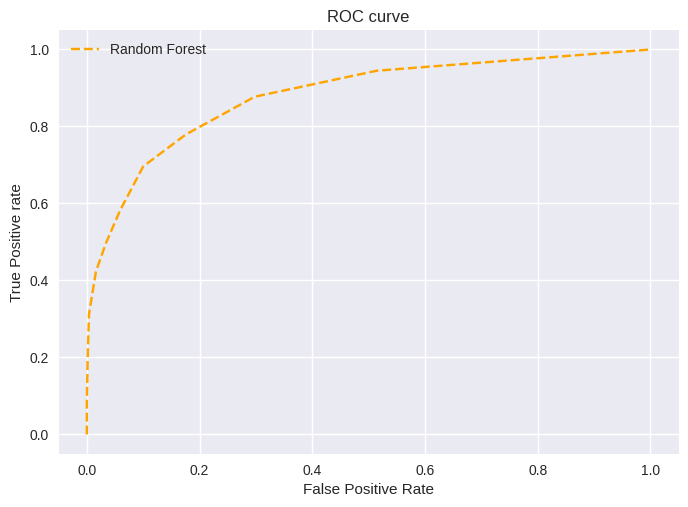

In [26]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();



Examine the learned feature importances output by the model as a sanity-check.


In [27]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)


,importance
alcohol,0.166131
density,0.106301
volatile_acidity,0.086660
pH,0.085085
sulphates,0.084661
total_sulfur_dioxide,0.082139
free_sulfur_dioxide,0.082102
citric_acid,0.081057
residual_sugar,0.079245
chlorides,0.078470


Experiment with a new model

The random forest model performed well even without hyperparameter tuning.

Now we can test it on a decision tree.


In [28]:
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1).
# The following code creates a wrapper function, SklearnModelWrapper, that uses
# the predict_proba method to return the probability that the observation belongs to each class.

model = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
model.fit(X_train, y_train)
dt_pred_train = model.predict(X_train)
dt_pred_test = model.predict(X_test)

# predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
predictions_test = model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, predictions_test)
fpr2, tpr2, thresh2 = roc_curve(y_test, predictions_test, pos_label=1)

print('AUC ',auc_score)
print('Training Set Evaluation F1-Score ',f1_score(y_train,dt_pred_train))
print('Testing Set Evaluation F1-Score ',f1_score(y_test,predictions_test))

tn, fp, fn, tp = confusion_matrix(y_train, dt_pred_train).ravel()
print("Training Set")
print('True Positives: ', tp, '\nTrue negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn)
tn, fp, fn, tp = confusion_matrix(y_test, dt_pred_test).ravel()
print("Testing Set")
print('True Positives: ', tp, '\nTrue negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn)

AUC  0.766694059139404
Training Set Evaluation F1-Score  1.0
Testing Set Evaluation F1-Score  0.6276923076923078
Training Set
True Positives:  951 
True negatives:  3921 
False positives:  0 
False negatives:  0
Testing Set
True Positives:  204 
True negatives:  1179 
False positives:  120 
False negatives:  122


<ipython-input-29-34e2b5d8aedb>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


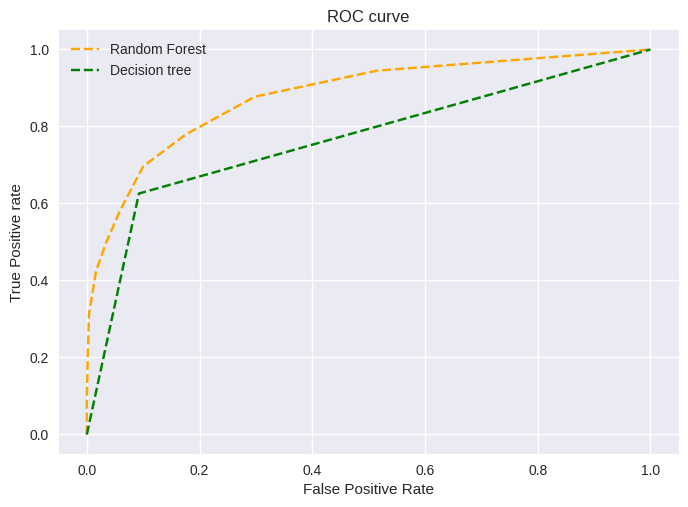

In [29]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision tree')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

And Anooother

And a N-Bayes?



In [30]:
import numpy as np
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1).
# The following code creates a wrapper function, SklearnModelWrapper, that uses
# the predict_proba method to return the probability that the observation belongs to each class.

model = GaussianNB()
model.fit(X_train, y_train)
dt_pred_train = model.predict(X_train)
dt_pred_test = model.predict(X_test)

# predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
predictions_test = model.predict_proba(X_test)[:,1]

# and we consider each value 1 if it's probability is over 0.5
predictions_processed = []

for pred in predictions_test:
  if pred >= 0.5:
    predictions_processed.append(1)
  else:
    predictions_processed.append(0)

auc_score = roc_auc_score(y_test, predictions_test)
fpr3, tpr3, thresh3 = roc_curve(y_test, predictions_test, pos_label=1)

print('AUC ',auc_score)
print('Training Set Evaluation F1-Score ',f1_score(y_train,dt_pred_train))
print('Testing Set Evaluation F1-Score ',f1_score(y_test,predictions_processed))

tn, fp, fn, tp = confusion_matrix(y_train, dt_pred_train).ravel()
print("Training Set")
print('True Positives: ', tp, '\nTrue negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn)
tn, fp, fn, tp = confusion_matrix(y_test, dt_pred_test).ravel()
print("Testing Set")
print('True Positives: ', tp, '\nTrue negatives: ', tn, '\nFalse positives: ', fp, '\nFalse negatives: ', fn)

AUC  0.7579780576847692
Training Set Evaluation F1-Score  0.4890510948905111
Testing Set Evaluation F1-Score  0.5051903114186852
Training Set
True Positives:  603 
True negatives:  3009 
False positives:  912 
False negatives:  348
Testing Set
True Positives:  219 
True negatives:  977 
False positives:  322 
False negatives:  107


<ipython-input-31-07a5ae02c6cc>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


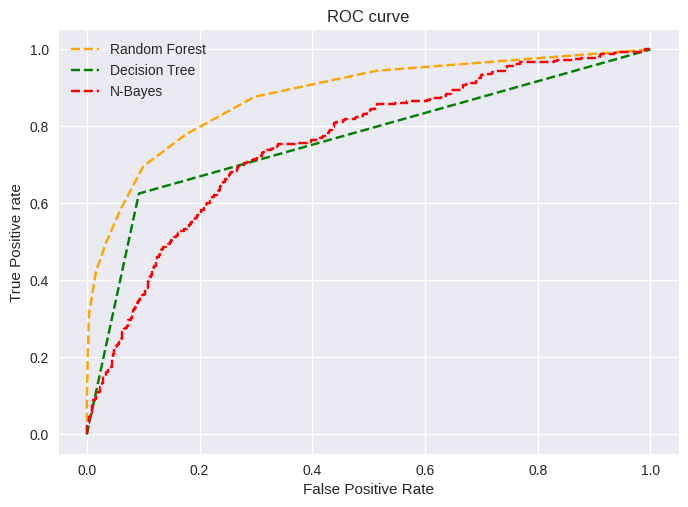

In [31]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision Tree')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='N-Bayes')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();